## Lesson 3 - Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Getting and converting the data

In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [6]:
cal = np.genfromtxt(path / '01' / 'rgb.cal', skip_footer=6)
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [18]:
fname = '09/frame_00667_rgb.jpg'

In [8]:
def img2txt_name(f): return path / f'{str(f)[:-7]}pose.txt'

In [20]:
img = open_image(path / fname)

In [21]:
img = open_image(path / fname)

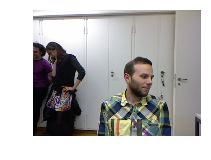

In [22]:
img.show()

In [23]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3)
ctr

array([187.332 ,  40.3892, 893.135 ])

In [24]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2, c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img, pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [25]:
get_ctr(fname)

tensor([263.9104, 428.5814])

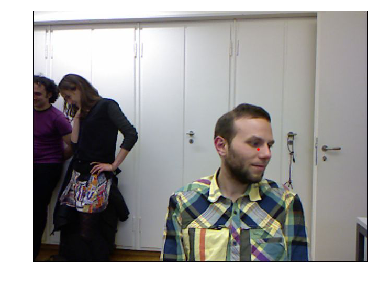

In [26]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [38]:
!ls /home/cedric/.fastai/data/biwi_head_pose/

01	04	07	10	13	16	19	22	io_sample.cpp
01.obj	04.obj	07.obj	10.obj	13.obj	16.obj	19.obj	22.obj	readme.txt
02	05	08	11	14	17	20	23
02.obj	05.obj	08.obj	11.obj	14.obj	17.obj	20.obj	23.obj
03	06	09	12	15	18	21	24
03.obj	06.obj	09.obj	12.obj	15.obj	18.obj	21.obj	24.obj


In [39]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

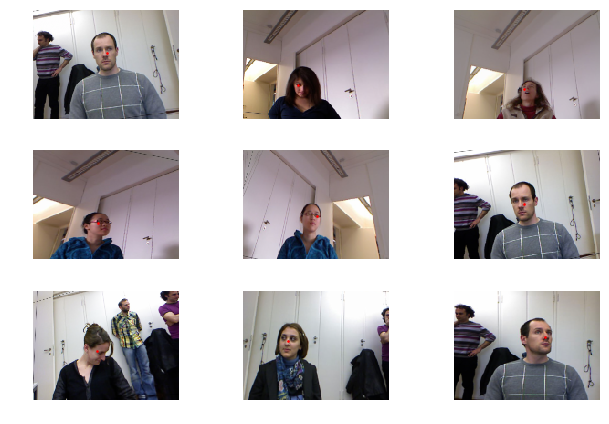

In [40]:
data.show_batch(3, figsize=(9,6))

## Train model

In [41]:
learn = create_cnn(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


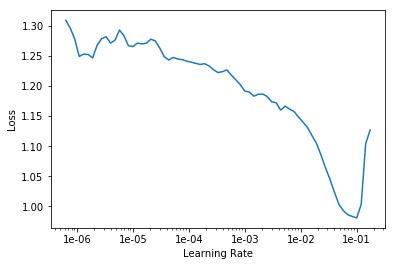

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
lr = 2e-2

In [44]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss
1,0.053352,0.040483
2,0.018844,0.011221
3,0.009006,0.001588
4,0.005284,0.000702
5,0.004040,0.001096


In [45]:
learn.save('stage-1')

In [46]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: PointsLabelList (15193 items)
[ImagePoints (480, 640), ImagePoints (480, 640), ImagePoints (480, 640), ImagePoints (480, 640), ImagePoints (480, 640)]...
Path: /home/cedric/.fastai/data/biwi_head_pose
x: PointsItemList (15193 items)
[Image (3, 480, 640), Image (3, 480, 640), Image (3, 480, 640), Image (3, 480, 640), Image (3, 480, 640)]...
Path: /home/cedric/.fastai/data/biwi_head_pose;

Valid: LabelList
y: PointsLabelList (485 items)
[ImagePoints (480, 640), ImagePoints (480, 640), ImagePoints (480, 640), ImagePoints (480, 640), ImagePoints (480, 640)]...
Path: /home/cedric/.fastai/data/biwi_head_pose
x: PointsItemList (485 items)
[Image (3, 480, 640), Image (3, 480, 640), Image (3, 480, 640), Image (3, 480, 640), Image (3, 480, 640)]...
Path: /home/cedric/.fastai/data/biwi_head_pose;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNor

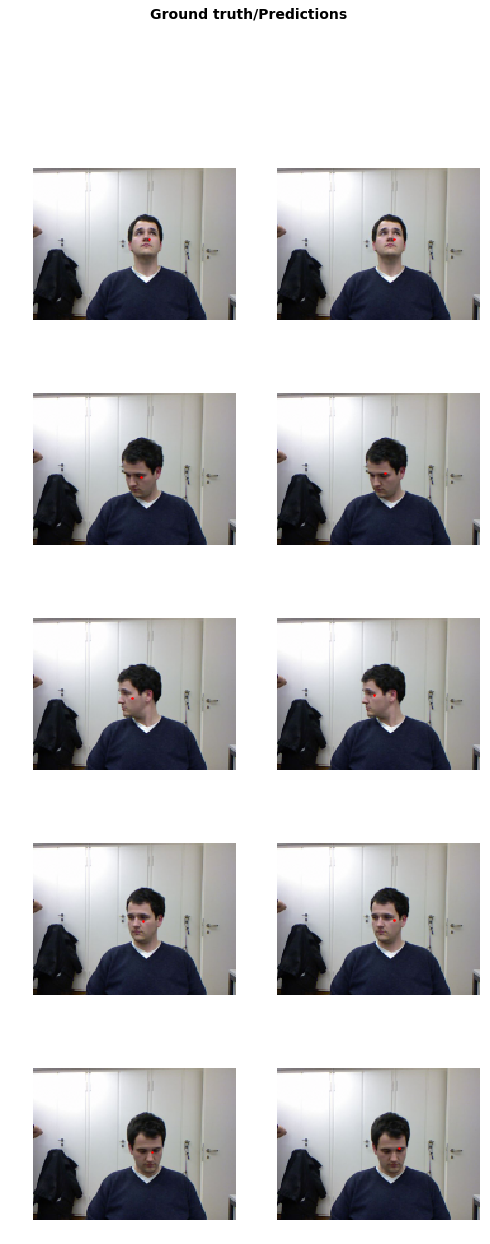

In [47]:
learn.show_results()

## Data augmentation

In [48]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

In [49]:
data = (ImageItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name == '13')
        .label_from_func(get_ctr, label_cls=PointsItemList)
        .transform(tfms, tfm_y=True, size=(120,160), padding_mode='zeros')
        .databunch().normalize(imagenet_stats)
       )

AttributeError: 'Tensor' object has no attribute 'read'

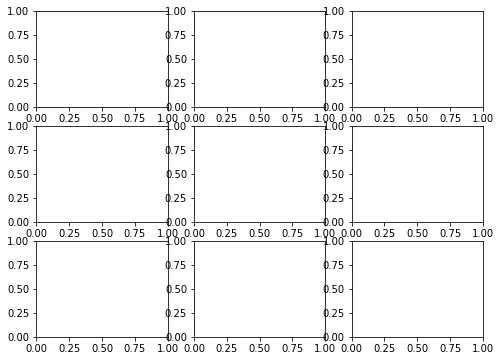

In [50]:
def _plot(i, j, ax):
    x, y = data.train_ds[0]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3, figsize=(8,6))